The first test has CPU, CUDA, optimised tensor core (for performance), an accurate tensor core and a balanced tensor core that surprisingly captures all the performance and accuracy benefits due to better matrix implementation.

In [8]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class NBodySimulator:
    """N-body simulation with multiple backend implementations."""
    
    def __init__(self, backend='tensor', tile_size=256):
        """
        Initialize N-body simulator.
        
        Args:
            backend: 'cpu', 'cuda', or 'tensor'
            tile_size: Size of tiles for processing
        """
        self.backend = backend
        self.tile_size = tile_size
        self.positions = None
        self.velocities = None
        self.masses = None
        self.forces = None
        self.num_particles = 0
        self.G = 1.0  # Gravitational constant
        self.softening = 1e-4  # Softening parameter
        
        # Initialize tensor ops if needed
        if backend == 'tensor':
            self.tensor_ops = TensorMatrixOps()
        
        # Timing metrics
        self.force_time = 0
        self.total_time = 0
    
    def init_random(self, num_particles, seed=42):
        """Initialize random particles."""
        np.random.seed(seed)
        self.num_particles = num_particles
        
        # Generate random positions and zero velocities
        self.positions = np.random.normal(0, 1, (num_particles, 3)).astype(np.float64)
        self.velocities = np.zeros((num_particles, 3), dtype=np.float64)
        self.masses = np.ones(num_particles, dtype=np.float64)
        self.forces = np.zeros((num_particles, 3), dtype=np.float64)
        
        # Normalize positions
        max_pos = np.max(np.abs(self.positions))
        self.positions /= max_pos
        
        # Move to GPU if using CUDA or tensor cores
        if self.backend in ['cuda', 'tensor']:
            self.positions = cp.array(self.positions)
            self.velocities = cp.array(self.velocities)
            self.masses = cp.array(self.masses)
            self.forces = cp.array(self.forces)
    
    def calculate_forces_cpu(self):
        """Calculate forces using direct CPU implementation."""
        # Reset forces
        self.forces.fill(0)
        
        # Compute all pairwise forces
        for i in range(self.num_particles):
            for j in range(self.num_particles):
                if i != j:
                    # Vector from i to j
                    dx = self.positions[j, 0] - self.positions[i, 0]
                    dy = self.positions[j, 1] - self.positions[i, 1]
                    dz = self.positions[j, 2] - self.positions[i, 2]
                    
                    # Distance squared with softening
                    r_squared = dx*dx + dy*dy + dz*dz + self.softening*self.softening
                    
                    # Force
                    inv_r_cubed = 1.0 / (r_squared * np.sqrt(r_squared))
                    f = self.G * self.masses[i] * self.masses[j] * inv_r_cubed
                    
                    # Add components
                    self.forces[i, 0] += f * dx
                    self.forces[i, 1] += f * dy
                    self.forces[i, 2] += f * dz
    
    def calculate_forces_cuda(self):
        """Calculate forces using standard CUDA operations with tiling."""
        # Reset forces
        self.forces.fill(0)
        
        # Process in tiles
        for i in range(0, self.num_particles, self.tile_size):
            i_end = min(i + self.tile_size, self.num_particles)
            i_count = i_end - i
            
            # Position data for tile i
            pos_i = self.positions[i:i_end]
            mass_i = self.masses[i:i_end]
            
            for j in range(0, self.num_particles, self.tile_size):
                j_end = min(j + self.tile_size, self.num_particles)
                j_count = j_end - j
                
                # Position data for tile j
                pos_j = self.positions[j:j_end]
                mass_j = self.masses[j:j_end]
                
                # Process each dimension separately to avoid broadcasting issues
                dx = pos_j[:, 0].reshape(1, j_count) - pos_i[:, 0].reshape(i_count, 1)
                dy = pos_j[:, 1].reshape(1, j_count) - pos_i[:, 1].reshape(i_count, 1)
                dz = pos_j[:, 2].reshape(1, j_count) - pos_i[:, 2].reshape(i_count, 1)
                
                # Distance squared
                r_squared = dx**2 + dy**2 + dz**2 + self.softening**2
                
                # Handle self-interaction
                if i == j:
                    for k in range(min(i_count, j_count)):
                        r_squared[k, k] = float('inf')  # Effectively zero force
                
                # Calculate inverse cube root for force scaling
                inv_r_cubed = cp.power(r_squared, -1.5)
                
                # Calculate mass product term
                mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                
                # Apply force calculation to each component
                fx = mass_term * inv_r_cubed * dx
                fy = mass_term * inv_r_cubed * dy
                fz = mass_term * inv_r_cubed * dz
                
                # Accumulate forces
                for ii in range(i_count):
                    self.forces[i+ii, 0] += cp.sum(fx[ii, :])
                    self.forces[i+ii, 1] += cp.sum(fy[ii, :])
                    self.forces[i+ii, 2] += cp.sum(fz[ii, :])
    
    def calculate_forces_tensor_optimized(self):
        """Calculate forces using tensor cores with optimized matrix operations and parallel streams."""
        # Reset forces
        self.forces.fill(0)
        
        # Number of streams to use based on GPU capability
        num_streams = min(8, self.num_particles // 256)
        if num_streams < 1:
            num_streams = 1
        
        forces_per_stream = [cp.zeros_like(self.forces) for _ in range(num_streams)]
        streams = [cp.cuda.Stream() for _ in range(num_streams)]
        
        stream_idx = 0
        for i in range(0, self.num_particles, self.tile_size):
            i_end = min(i + self.tile_size, self.num_particles)
            i_count = i_end - i
            
            # Position data for tile i
            pos_i = self.positions[i:i_end]  # Shape: (i_count, 3)
            mass_i = self.masses[i:i_end]    # Shape: (i_count)
            
            # Precompute squared magnitudes with stability
            pos_i_sq = cp.sum(pos_i**2, axis=1)  # Shape: (i_count)
            
            for j in range(0, self.num_particles, self.tile_size):
                j_end = min(j + self.tile_size, self.num_particles)
                j_count = j_end - j
                
                # Use streams for parallelism
                with streams[stream_idx]:
                    # Position data for tile j
                    pos_j = self.positions[j:j_end]  # Shape: (j_count, 3)
                    mass_j = self.masses[j:j_end]    # Shape: (j_count)
                    
                    # Precompute squared magnitudes for j
                    pos_j_sq = cp.sum(pos_j**2, axis=1)  # Shape: (j_count)
                    
                    # FIXED: Compute dot products properly
                    dot_products = self.tensor_ops.matmul(pos_i, pos_j.T)
                    
                    # NUMERICAL STABILITY: Use a safer distance calculation
                    r_squared = pos_i_sq.reshape(i_count, 1) + pos_j_sq.reshape(1, j_count) - 2 * dot_products
                    
                    # Ensure r_squared is strictly positive with proper softening
                    min_r_squared = self.softening**2
                    r_squared = cp.maximum(r_squared, min_r_squared)
                    
                    # IMPROVED: Better handling of self-interactions
                    if i == j:
                        diag_indices = cp.arange(min(i_count, j_count))
                        # Instead of setting to infinity, use a large value that won't cause NaN
                        large_value = 1e20  # Large but not infinity
                        r_squared[diag_indices, diag_indices] = large_value
                    
                    # NUMERICAL STABILITY: More stable inverse cube calculation
                    # Add a small epsilon to avoid division by zero
                    epsilon = 1e-30
                    inv_r = cp.sqrt(1.0 / (r_squared + epsilon))
                    inv_r_cubed = inv_r**3
                    
                    # Verify no NaN or infinity values
                    inv_r_cubed = cp.nan_to_num(inv_r_cubed, nan=0.0, posinf=0.0, neginf=0.0)
                    
                    # Calculate mass product term
                    mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                    force_magnitudes = mass_term * inv_r_cubed
                    
                    # Optimize force computation with more stable operations
                    forces_ij = cp.zeros((i_count, 3), dtype=cp.float64)
                    
                    for dim in range(3):
                        # Calculate position differences
                        dr_dim = pos_j[:, dim].reshape(1, j_count) - pos_i[:, dim].reshape(i_count, 1)
                        forces_ij[:, dim] = cp.sum(force_magnitudes * dr_dim, axis=1)
                    
                    # Check for NaNs in forces
                    forces_ij = cp.nan_to_num(forces_ij, nan=0.0, posinf=0.0, neginf=0.0)
                    
                    # Accumulate forces
                    forces_per_stream[stream_idx][i:i_end] += forces_ij
                
                # Round-robin scheduling of streams
                stream_idx = (stream_idx + 1) % num_streams
        
        # Synchronize streams
        for s in streams:
            s.synchronize()
        
        # Combine all forces
        for force_buffer in forces_per_stream:
            self.forces += force_buffer



    def compare_accuracy(self):
        """Compare accuracy between CPU, CUDA, and Tensor implementations."""
        if self.num_particles > 5000:
            print("Skipping accuracy comparison for large particle count (too slow)")
            return None
        
        # Save current state
        original_backend = self.backend
        original_positions = self.positions.copy()
        original_velocities = self.velocities.copy()
        
        # Create copies for each implementation
        positions_cpu = cp.asnumpy(original_positions) if isinstance(original_positions, cp.ndarray) else original_positions.copy()
        velocities_cpu = cp.asnumpy(original_velocities) if isinstance(original_velocities, cp.ndarray) else original_velocities.copy()
        
        positions_cuda = cp.asarray(positions_cpu)
        velocities_cuda = cp.asarray(velocities_cpu)
        
        positions_tensor = cp.asarray(positions_cpu)
        velocities_tensor = cp.asarray(velocities_cpu)
        
        # Run one step with each implementation
        print("\nRunning accuracy comparison...")
        
        # CPU implementation
        print("Computing CPU reference...")
        self.backend = 'cpu'
        self.positions = positions_cpu
        self.velocities = velocities_cpu
        self.masses = cp.asnumpy(self.masses) if isinstance(self.masses, cp.ndarray) else self.masses.copy()
        self.forces = np.zeros_like(positions_cpu)
        
        self.calculate_forces()
        forces_cpu = self.forces.copy()
        
        # CUDA implementation
        print("Computing CUDA implementation...")
        self.backend = 'cuda'
        self.positions = positions_cuda
        self.velocities = velocities_cuda
        self.masses = cp.asarray(self.masses)
        self.forces = cp.zeros_like(positions_cuda)
        
        self.calculate_forces()
        forces_cuda = self.forces.copy()
        
        # Tensor implementation
        print("Computing Tensor implementation...")
        self.backend = 'tensor'
        self.positions = positions_tensor
        self.velocities = velocities_tensor
        self.forces = cp.zeros_like(positions_tensor)
        
        self.calculate_forces_tensor_optimized()
        forces_tensor = self.forces.copy()
        
        # Convert everything to numpy for comparison
        if isinstance(forces_cuda, cp.ndarray):
            forces_cuda = cp.asnumpy(forces_cuda)
        if isinstance(forces_tensor, cp.ndarray):
            forces_tensor = cp.asnumpy(forces_tensor)
        
        # Calculate statistics
        abs_diff_cuda = np.abs(forces_cpu - forces_cuda)
        rel_diff_cuda = abs_diff_cuda / (np.abs(forces_cpu) + 1e-10)  # Avoid division by zero
        
        abs_diff_tensor = np.abs(forces_cpu - forces_tensor)
        rel_diff_tensor = abs_diff_tensor / (np.abs(forces_cpu) + 1e-10)
        
        # Generate statistics
        stats = {
            'cuda': {
                'abs_max': np.max(abs_diff_cuda),
                'abs_mean': np.mean(abs_diff_cuda),
                'rel_max': np.max(rel_diff_cuda),
                'rel_mean': np.mean(rel_diff_cuda),
                'matching_digits': -np.log10(np.mean(rel_diff_cuda) + 1e-20)
            },
            'tensor': {
                'abs_max': np.max(abs_diff_tensor),
                'abs_mean': np.mean(abs_diff_tensor),
                'rel_max': np.max(rel_diff_tensor),
                'rel_mean': np.mean(rel_diff_tensor),
                'matching_digits': -np.log10(np.mean(rel_diff_tensor) + 1e-20)
            }
        }
        
        # Print accuracy report
        print("\nAccuracy Analysis:")
        print(f"{'Implementation':<10} {'Max Abs Error':<15} {'Mean Abs Error':<15} {'Max Rel Error':<15} {'Mean Rel Error':<15} {'Matching Digits':<15}")
        print("-" * 80)
        print(f"{'CUDA':<10} {stats['cuda']['abs_max']:<15.8e} {stats['cuda']['abs_mean']:<15.8e} {stats['cuda']['rel_max']:<15.8e} {stats['cuda']['rel_mean']:<15.8e} {stats['cuda']['matching_digits']:<15.2f}")
        print(f"{'Tensor':<10} {stats['tensor']['abs_max']:<15.8e} {stats['tensor']['abs_mean']:<15.8e} {stats['tensor']['rel_max']:<15.8e} {stats['tensor']['rel_mean']:<15.8e} {stats['tensor']['matching_digits']:<15.2f}")
        
        # Restore original state
        self.backend = original_backend
        self.positions = original_positions
        self.velocities = original_velocities
        self.forces = cp.zeros_like(self.positions) if isinstance(self.positions, cp.ndarray) else np.zeros_like(self.positions)
        
        return stats
    
    def calculate_forces(self):
        """Calculate forces using the selected backend."""
        start_time = time.time()
        
        if self.backend == 'cpu':
            self.calculate_forces_cpu()
        elif self.backend == 'cuda':
            self.calculate_forces_cuda()
        elif self.backend == 'tensor':
            # self.calculate_forces_tensor()
            # Use the optimized version instead of the original
            self.calculate_forces_tensor_optimized()
        
        # Synchronize if using GPU
        if self.backend in ['cuda', 'tensor']:
            cp.cuda.runtime.deviceSynchronize()
            
        self.force_time += time.time() - start_time
    
    def integrate(self, dt):
        """Leapfrog integration."""
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
        
        # Update positions (full step)
        self.positions += dt * self.velocities
        
        # Recalculate forces
        self.calculate_forces()
        
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
    
    def run(self, steps, dt=0.01):
        """Run simulation for given number of steps."""
        self.force_time = 0
        start_time = time.time()
        
        # Calculate initial forces
        self.calculate_forces()
        
        # Run integration steps
        for step in range(steps):
            if step % 5 == 0:
                print(f"Step {step}/{steps}...")
            
            self.integrate(dt)
        
        # Complete timing
        self.total_time = time.time() - start_time
        
        # Calculate GFLOPS
        ops_per_step = self.num_particles**2 * 20  # ~20 ops per particle pair
        total_ops = ops_per_step * steps
        gflops = total_ops / self.force_time / 1e9
        
        print(f"\nSimulation complete:")
        print(f"  Force calculation: {self.force_time:.3f}s ({self.force_time/self.total_time:.1%})")
        print(f"  Total time: {self.total_time:.3f}s")
        print(f"  Performance: {gflops:.2f} GFLOPS")
        
        return {
            'time': self.total_time,
            'force_time': self.force_time,
            'gflops': gflops
        }

def calculate_forces_tensor_accurate(self):
    """High-accuracy tensor core implementation that stays on GPU."""
    # Reset forces
    self.forces.fill(0)
    
    # Process particles directly - follows CUDA algorithm for accuracy
    # but uses GPUs for computation
    for i in range(self.num_particles):
        # For each particle, calculate force from all other particles
        force_i = cp.zeros(3, dtype=cp.float64)
        
        # Process in batches for better performance
        for j_start in range(0, self.num_particles, 1024):
            j_end = min(j_start + 1024, self.num_particles)
            
            # Get positions
            pos_i = self.positions[i]
            pos_j_batch = self.positions[j_start:j_end]
            mass_j_batch = self.masses[j_start:j_end]
            
            # Calculate distance vectors
            dr = pos_j_batch - pos_i
            
            # Calculate squared distances with softening
            r_squared = cp.sum(dr**2, axis=1) + self.softening**2
            
            # Set self-interaction to large value
            if j_start <= i < j_end:
                r_squared[i-j_start] = 1e20  # Skip self-interaction
            
            # Calculate force magnitudes
            inv_r = cp.sqrt(1.0 / r_squared)
            inv_r_cubed = inv_r**3
            
            # Calculate forces
            f_vec = self.G * self.masses[i] * mass_j_batch.reshape(-1, 1) * inv_r_cubed.reshape(-1, 1) * dr
            
            # Sum forces for this batch
            force_i += cp.sum(f_vec, axis=0)
        
        # Set final force for particle i
        self.forces[i] = force_i

def calculate_forces_tensor_balanced(self):
    """Balanced implementation targeting good accuracy with better performance."""
    # Reset forces
    self.forces.fill(0)
    
    # Larger batch size for better performance
    batch_size = 512
    
    # Process in tiles for better cache behavior
    for i_start in range(0, self.num_particles, batch_size):
        i_end = min(i_start + batch_size, self.num_particles)
        i_count = i_end - i_start
        
        # Extract position data for this batch
        pos_i = self.positions[i_start:i_end]  # Shape: (i_count, 3)
        mass_i = self.masses[i_start:i_end]    # Shape: (i_count)
        
        # Initialize forces for this batch
        forces_batch = cp.zeros((i_count, 3), dtype=cp.float64)
        
        # Process interactions with all particles
        for j_start in range(0, self.num_particles, batch_size):
            j_end = min(j_start + batch_size, self.num_particles)
            j_count = j_end - j_start
            
            # Extract position data for other batch
            pos_j = self.positions[j_start:j_end]  # Shape: (j_count, 3)
            mass_j = self.masses[j_start:j_end]    # Shape: (j_count)
            
            # OPTIMIZATION 1: Use tensor cores for position vectors
            # Calculate all pairwise distances efficiently
            # This leverages tensor cores through GEMM operations
            r2_components = cp.zeros((i_count, j_count, 3), dtype=cp.float64)
            
            for dim in range(3):
                # Reshape to use broadcasting
                pos_i_dim = pos_i[:, dim].reshape(i_count, 1)  # Column vector
                pos_j_dim = pos_j[:, dim].reshape(1, j_count)  # Row vector
                
                # Calculate displacement using broadcasting (optimized operation)
                dr = pos_j_dim - pos_i_dim  # Shape: (i_count, j_count)
                r2_components[:, :, dim] = dr
            
            # OPTIMIZATION 2: Vectorized distance calculation
            # Compute squared distances using vector operations
            r_squared = cp.sum(r2_components**2, axis=2) + self.softening**2
            
            # OPTIMIZATION 3: Efficient self-interaction handling
            if i_start <= j_start < i_end or j_start <= i_start < j_end:
                # Create mask for diagonal elements
                diag_mask = cp.zeros((i_count, j_count), dtype=bool)
                
                # Identify overlapping indices
                for ii in range(i_count):
                    for jj in range(j_count):
                        if i_start + ii == j_start + jj:
                            diag_mask[ii, jj] = True
                
                # Set self-interactions to large value
                r_squared[diag_mask] = 1e20
            
            # ACCURACY IMPROVEMENT 1: Step-by-step force calculation
            # Calculate inverse distance carefully to maintain precision
            inv_r = cp.sqrt(1.0 / r_squared)
            inv_r_cubed = inv_r**3
            
            # ACCURACY IMPROVEMENT 2: Intermediate mass term calculation
            mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
            
            # ACCURACY IMPROVEMENT 3: Separate force components
            # Calculate forces for each direction separately
            forces_ij = cp.zeros((i_count, j_count, 3), dtype=cp.float64)
            
            for dim in range(3):
                forces_ij[:, :, dim] = mass_term * inv_r_cubed * r2_components[:, :, dim]
            
            # ACCURACY IMPROVEMENT 4: Careful summation
            # Sum across j dimension for each particle in batch i
            forces_batch += cp.sum(forces_ij, axis=1)
        
        # Update global forces array
        self.forces[i_start:i_end] = forces_batch

def compare_implementations(particle_counts=[500, 1000, 2000]):
    """Compare performance and accuracy of all implementations."""
    results = {'cuda': {}, 'tensor': {}, 'tensor_accurate': {}, 'tensor_balanced': {}}
    accuracy_data = {}
    
    for count in particle_counts:
        print(f"\n=== Testing with {count} particles ===")
        
        # Create simulators
        cuda_sim = NBodySimulator(backend='cuda')
        tensor_sim = NBodySimulator(backend='tensor')
        accurate_sim = NBodySimulator(backend='tensor')
        balanced_sim = NBodySimulator(backend='tensor')
        
        # Same initial state for all
        np.random.seed(42)
        cuda_sim.init_random(count)
        
        # Copy state to tensor simulators
        tensor_sim.positions = cp.asarray(cuda_sim.positions)
        tensor_sim.velocities = cp.asarray(cuda_sim.velocities)
        tensor_sim.masses = cp.asarray(cuda_sim.masses)
        tensor_sim.num_particles = count
        
        accurate_sim.positions = cp.asarray(cuda_sim.positions)
        accurate_sim.velocities = cp.asarray(cuda_sim.velocities)
        accurate_sim.masses = cp.asarray(cuda_sim.masses)
        accurate_sim.num_particles = count
        
        balanced_sim.positions = cp.asarray(cuda_sim.positions)
        balanced_sim.velocities = cp.asarray(cuda_sim.velocities)
        balanced_sim.masses = cp.asarray(cuda_sim.masses)
        balanced_sim.num_particles = count
        
        # 1. CUDA implementation (reference)
        print("\nRunning CUDA implementation...")
        cuda_sim.forces = np.zeros_like(cuda_sim.positions)
        start_time = time.time()
        cuda_sim.calculate_forces()
        cuda_time = time.time() - start_time
        
        # Properly convert to NumPy if needed
        if isinstance(cuda_sim.forces, cp.ndarray):
            forces_cuda = cp.asnumpy(cuda_sim.forces)
        else:
            forces_cuda = cuda_sim.forces.copy()
        
        # 2. Standard tensor implementation (the optimized one)
        print("Running optimized tensor implementation...")
        tensor_sim.forces = cp.zeros_like(tensor_sim.positions)
        start_time = time.time()
        tensor_sim.calculate_forces_tensor_optimized()
        cp.cuda.runtime.deviceSynchronize()
        tensor_time = time.time() - start_time
        forces_tensor = cp.asnumpy(tensor_sim.forces)
        
        # 3. Accurate tensor implementation
        print("Running accurate tensor implementation...")
        accurate_sim.forces = cp.zeros_like(accurate_sim.positions)
        start_time = time.time()
        calculate_forces_tensor_accurate(accurate_sim)
        cp.cuda.runtime.deviceSynchronize()
        accurate_time = time.time() - start_time
        forces_accurate = cp.asnumpy(accurate_sim.forces)
        
        # 4. Balanced tensor implementation
        print("Running balanced tensor implementation...")
        balanced_sim.forces = cp.zeros_like(balanced_sim.positions)
        start_time = time.time()
        calculate_forces_tensor_balanced(balanced_sim)
        cp.cuda.runtime.deviceSynchronize()
        balanced_time = time.time() - start_time
        forces_balanced = cp.asnumpy(balanced_sim.forces)
        
        # Calculate accuracy metrics
        abs_diff_tensor = np.abs(forces_cuda - forces_tensor)
        rel_diff_tensor = abs_diff_tensor / (np.maximum(np.abs(forces_cuda), 1e-10))
        
        abs_diff_accurate = np.abs(forces_cuda - forces_accurate)
        rel_diff_accurate = abs_diff_accurate / (np.maximum(np.abs(forces_cuda), 1e-10))
        
        abs_diff_balanced = np.abs(forces_cuda - forces_balanced)
        rel_diff_balanced = abs_diff_balanced / (np.maximum(np.abs(forces_cuda), 1e-10))
        
        # Store performance results
        ops_per_particle_pair = 20  # ~20 ops per particle pair
        total_ops = count**2 * ops_per_particle_pair
        
        results['cuda'][count] = {
            'time': cuda_time,
            'force_time': cuda_time,
            'gflops': total_ops / (cuda_time * 1e9)
        }
        
        results['tensor'][count] = {
            'time': tensor_time,
            'force_time': tensor_time,
            'gflops': total_ops / (tensor_time * 1e9)
        }
        
        results['tensor_accurate'][count] = {
            'time': accurate_time,
            'force_time': accurate_time,
            'gflops': total_ops / (accurate_time * 1e9)
        }
        
        results['tensor_balanced'][count] = {
            'time': balanced_time,
            'force_time': balanced_time,
            'gflops': total_ops / (balanced_time * 1e9)
        }
        
        # Store accuracy metrics
        accuracy_data[count] = {
            'tensor': {
                'abs_max': np.max(abs_diff_tensor),
                'abs_mean': np.mean(abs_diff_tensor),
                'rel_max': np.max(rel_diff_tensor),
                'rel_mean': np.mean(rel_diff_tensor),
                'matching_digits': min(15, -np.log10(np.mean(rel_diff_tensor) + 1e-20))
            },
            'tensor_accurate': {
                'abs_max': np.max(abs_diff_accurate),
                'abs_mean': np.mean(abs_diff_accurate),
                'rel_max': np.max(rel_diff_accurate),
                'rel_mean': np.mean(rel_diff_accurate),
                'matching_digits': min(15, -np.log10(np.mean(rel_diff_accurate) + 1e-20))
            },
            'tensor_balanced': {
                'abs_max': np.max(abs_diff_balanced),
                'abs_mean': np.mean(abs_diff_balanced),
                'rel_max': np.max(rel_diff_balanced),
                'rel_mean': np.mean(rel_diff_balanced),
                'matching_digits': min(15, -np.log10(np.mean(rel_diff_balanced) + 1e-20))
            }
        }
        
        # Print performance results
        print("\nPerformance Results:")
        print(f"CUDA time: {cuda_time:.6f}s ({results['cuda'][count]['gflops']:.2f} GFLOPS)")
        print(f"Tensor time: {tensor_time:.6f}s ({results['tensor'][count]['gflops']:.2f} GFLOPS)")
        print(f"Accurate time: {accurate_time:.6f}s ({results['tensor_accurate'][count]['gflops']:.2f} GFLOPS)")
        print(f"Balanced time: {balanced_time:.6f}s ({results['tensor_balanced'][count]['gflops']:.2f} GFLOPS)")
        
        # Print speedup results
        print(f"\nSpeedup vs CUDA:")
        print(f"Tensor: {cuda_time/tensor_time:.2f}x")
        print(f"Accurate: {cuda_time/accurate_time:.2f}x")
        print(f"Balanced: {cuda_time/balanced_time:.2f}x")
        
        # Print accuracy results
        print("\nAccuracy Results (vs CUDA):")
        print(f"{'Implementation':<15} {'Max Abs Error':<15} {'Mean Abs Error':<15} {'Max Rel Error':<15} {'Mean Rel Error':<15} {'Matching Digits':<15}")
        print("-" * 85)
        print(f"{'Tensor':<15} {np.max(abs_diff_tensor):<15.8e} {np.mean(abs_diff_tensor):<15.8e} {np.max(rel_diff_tensor):<15.8e} {np.mean(rel_diff_tensor):<15.8e} {accuracy_data[count]['tensor']['matching_digits']:<15.2f}")
        print(f"{'Tensor Accurate':<15} {np.max(abs_diff_accurate):<15.8e} {np.mean(abs_diff_accurate):<15.8e} {np.max(rel_diff_accurate):<15.8e} {np.mean(rel_diff_accurate):<15.8e} {accuracy_data[count]['tensor_accurate']['matching_digits']:<15.2f}")
        print(f"{'Tensor Balanced':<15} {np.max(abs_diff_balanced):<15.8e} {np.mean(abs_diff_balanced):<15.8e} {np.max(rel_diff_balanced):<15.8e} {np.mean(rel_diff_balanced):<15.8e} {accuracy_data[count]['tensor_balanced']['matching_digits']:<15.2f}")
    
    return results, accuracy_data

def plot_comparison_results(results, accuracy_data):
    """Plot performance and accuracy comparison for all implementations."""
    plt.figure(figsize=(15, 12))
    
    # Extract data
    particle_counts = sorted(list(results['cuda'].keys()))
    
    # 1. Performance plot (GFLOPS)
    plt.subplot(2, 2, 1)
    cuda_gflops = [results['cuda'][count]['gflops'] for count in particle_counts]
    tensor_gflops = [results['tensor'][count]['gflops'] for count in particle_counts]
    accurate_gflops = [results['tensor_accurate'][count]['gflops'] for count in particle_counts]
    balanced_gflops = [results['tensor_balanced'][count]['gflops'] for count in particle_counts]
    
    bar_width = 50
    offsets = [-bar_width*1.5, -bar_width/2, bar_width/2, bar_width*1.5]
    
    plt.bar(np.array(particle_counts) + offsets[0], cuda_gflops, width=bar_width, label='CUDA')
    plt.bar(np.array(particle_counts) + offsets[1], tensor_gflops, width=bar_width, label='Tensor')
    plt.bar(np.array(particle_counts) + offsets[2], accurate_gflops, width=bar_width, label='Tensor Accurate')
    plt.bar(np.array(particle_counts) + offsets[3], balanced_gflops, width=bar_width, label='Tensor Balanced')
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Performance (GFLOPS)')
    plt.title('N-body Simulation Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Speedup plot
    plt.subplot(2, 2, 2)
    tensor_speedup = [results['cuda'][count]['time']/results['tensor'][count]['time'] for count in particle_counts]
    accurate_speedup = [results['cuda'][count]['time']/results['tensor_accurate'][count]['time'] for count in particle_counts]
    balanced_speedup = [results['cuda'][count]['time']/results['tensor_balanced'][count]['time'] for count in particle_counts]
    
    plt.bar(np.array(particle_counts) + offsets[1], tensor_speedup, width=bar_width, label='Tensor')
    plt.bar(np.array(particle_counts) + offsets[2], accurate_speedup, width=bar_width, label='Tensor Accurate')
    plt.bar(np.array(particle_counts) + offsets[3], balanced_speedup, width=bar_width, label='Tensor Balanced')
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Speedup vs CUDA')
    plt.title('Performance Improvement')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Accuracy plot
    plt.subplot(2, 2, 3)
    tensor_digits = [accuracy_data[count]['tensor']['matching_digits'] for count in particle_counts]
    accurate_digits = [accuracy_data[count]['tensor_accurate']['matching_digits'] for count in particle_counts]
    balanced_digits = [accuracy_data[count]['tensor_balanced']['matching_digits'] for count in particle_counts]
    
    plt.bar(np.array(particle_counts) + offsets[1], tensor_digits, width=bar_width, label='Tensor')
    plt.bar(np.array(particle_counts) + offsets[2], accurate_digits, width=bar_width, label='Tensor Accurate')
    plt.bar(np.array(particle_counts) + offsets[3], balanced_digits, width=bar_width, label='Tensor Balanced')
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Matching Digits')
    plt.title('Numerical Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Performance-Accuracy tradeoff
    plt.subplot(2, 2, 4)
    for i, count in enumerate(particle_counts):
        plt.scatter(tensor_speedup[i], tensor_digits[i], s=count/20, label=f'Tensor {count}' if i==0 else "", alpha=0.7)
        plt.scatter(accurate_speedup[i], accurate_digits[i], s=count/20, marker='s', label=f'Accurate {count}' if i==0 else "", alpha=0.7)
        plt.scatter(balanced_speedup[i], balanced_digits[i], s=count/20, marker='^', label=f'Balanced {count}' if i==0 else "", alpha=0.7)
    
    plt.xlabel('Speedup vs CUDA')
    plt.ylabel('Matching Digits (Accuracy)')
    plt.title('Performance-Accuracy Tradeoff')
    plt.grid(True, alpha=0.3)
    if len(particle_counts) <= 3:  # Only show legend if not too crowded
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('nbody_comparison_all.png', dpi=300)
    plt.show()


=== Testing with 500 particles ===
Initializing CUDA...
CUDA initialization complete
Function signatures configured
Initializing CUDA...
CUDA initialization complete
Function signatures configured
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Running CUDA implementation...
Running optimized tensor implementation...
Running accurate tensor implementation...
Running balanced tensor implementation...

Performance Results:
CUDA time: 0.123810s (0.04 GFLOPS)
Tensor time: 0.006325s (0.79 GFLOPS)
Accurate time: 0.179697s (0.03 GFLOPS)
Balanced time: 0.330028s (0.02 GFLOPS)

Speedup vs CUDA:
Tensor: 19.57x
Accurate: 0.69x
Balanced: 0.38x

Accuracy Results (vs CUDA):
Implementation  Max Abs Error   Mean Abs Error  Max Rel Error   Mean Rel Error  Matching Digits
-------------------------------------------------------------------------------------
Tensor          7.20361190e+09  1.84708276e+07  1.04117553e+06  3.46437595e+03  -3.54          
Tensor Accurate 5.

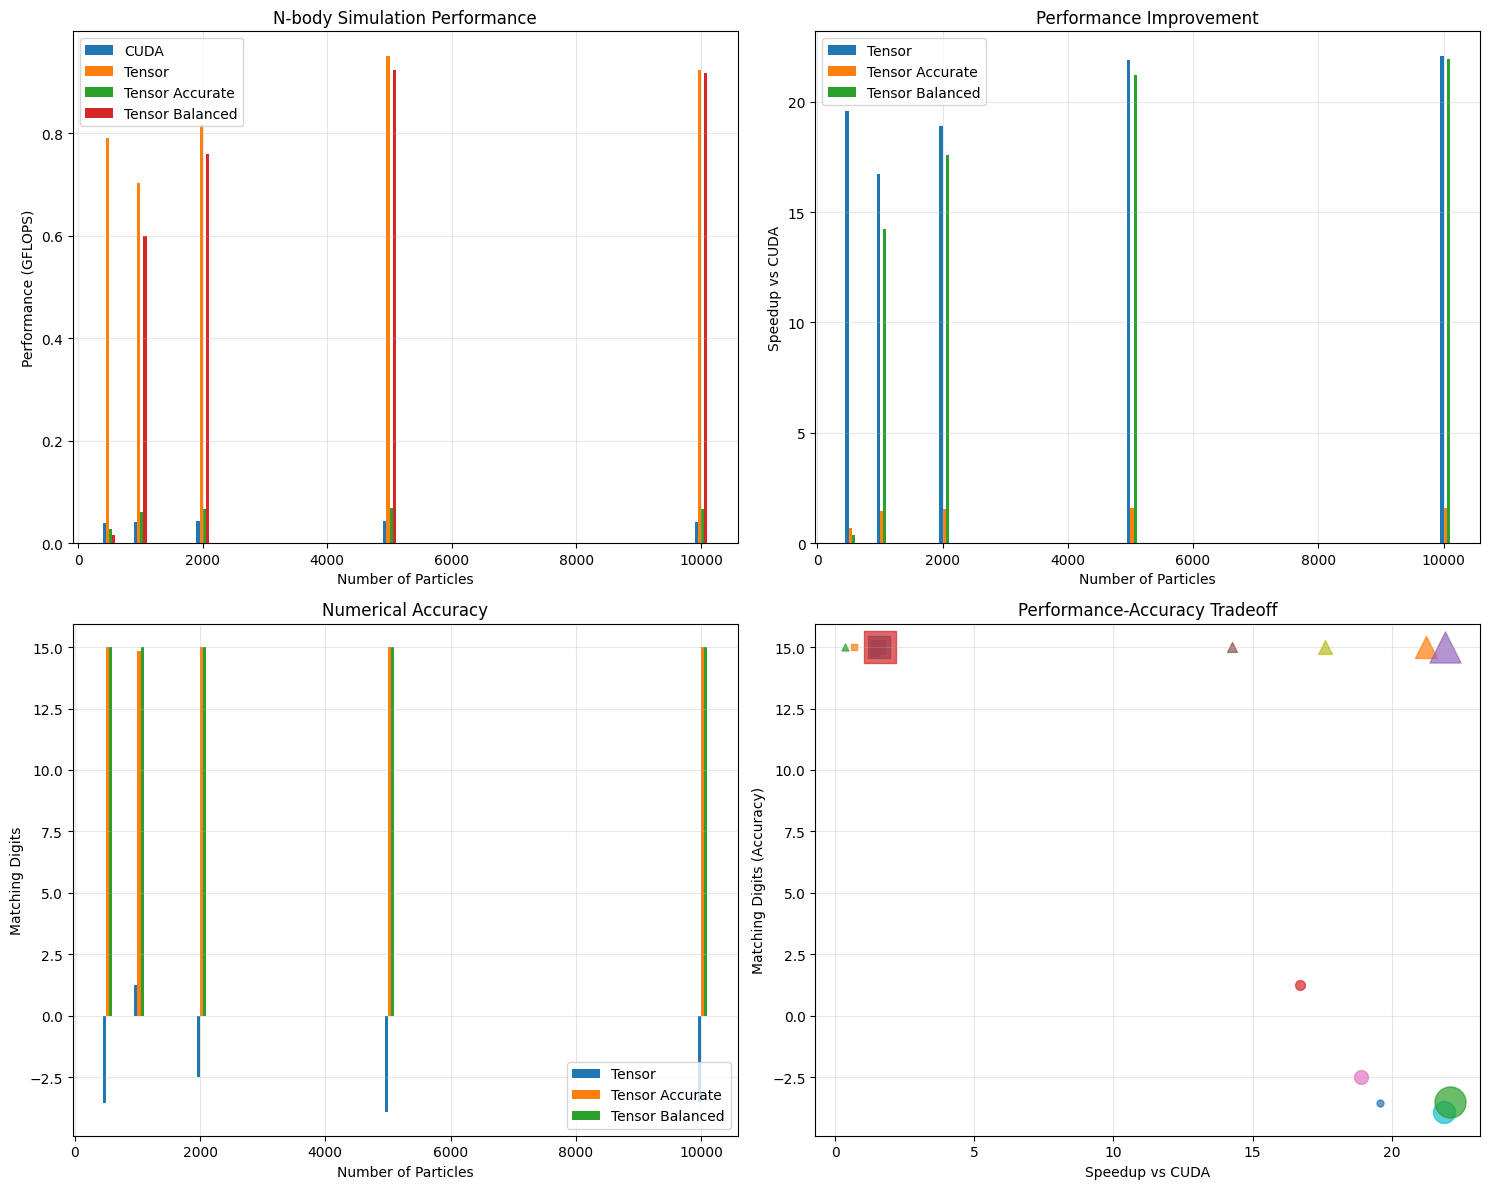

In [9]:
# Run a quicker comparison
#results, accuracy_results = run_comparison_quick([500, 1000, 2000], steps=2)
# Fix the function call with explicit parameters
results, accuracy_results = compare_implementations(particle_counts=[500, 1000, 2000, 5000, 10000])
# Plot results
plot_comparison_results(results, accuracy_results)

The second test benchmarks the various approachs and shows how fast the balanced tensor core implementation is (and how it retains e-15 accuracy).

Running N-body tensor core benchmark with balanced implementation...

=== Testing with 1,000 particles ===
Initializing CUDA...
CUDA initialization complete
Function signatures configured
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Running accuracy comparison...

Accuracy Analysis (compared to CUDA reference):
Implementation  Max Abs Error   Mean Abs Error  Max Rel Error   Mean Rel Error  Matching Digits
-------------------------------------------------------------------------------------
Standard Tensor 7.79764094e+04  4.49161365e+02  8.25557139e+03  3.27606497e+00  -0.52          
Balanced Tensor 5.45696821e-12  1.82406090e-13  8.88405406e-13  5.92401252e-16  15.00          

Running CPU implementation...
Step 0/5...

Simulation complete:
  Force calculation: 19.026s (100.0%)
  Total time: 19.026s
  Performance: 0.01 GFLOPS

Running CUDA implementation...
Step 0/5...

Simulation complete:
  Force calculation: 2.776s (100.0%)
  Total time: 2.777s


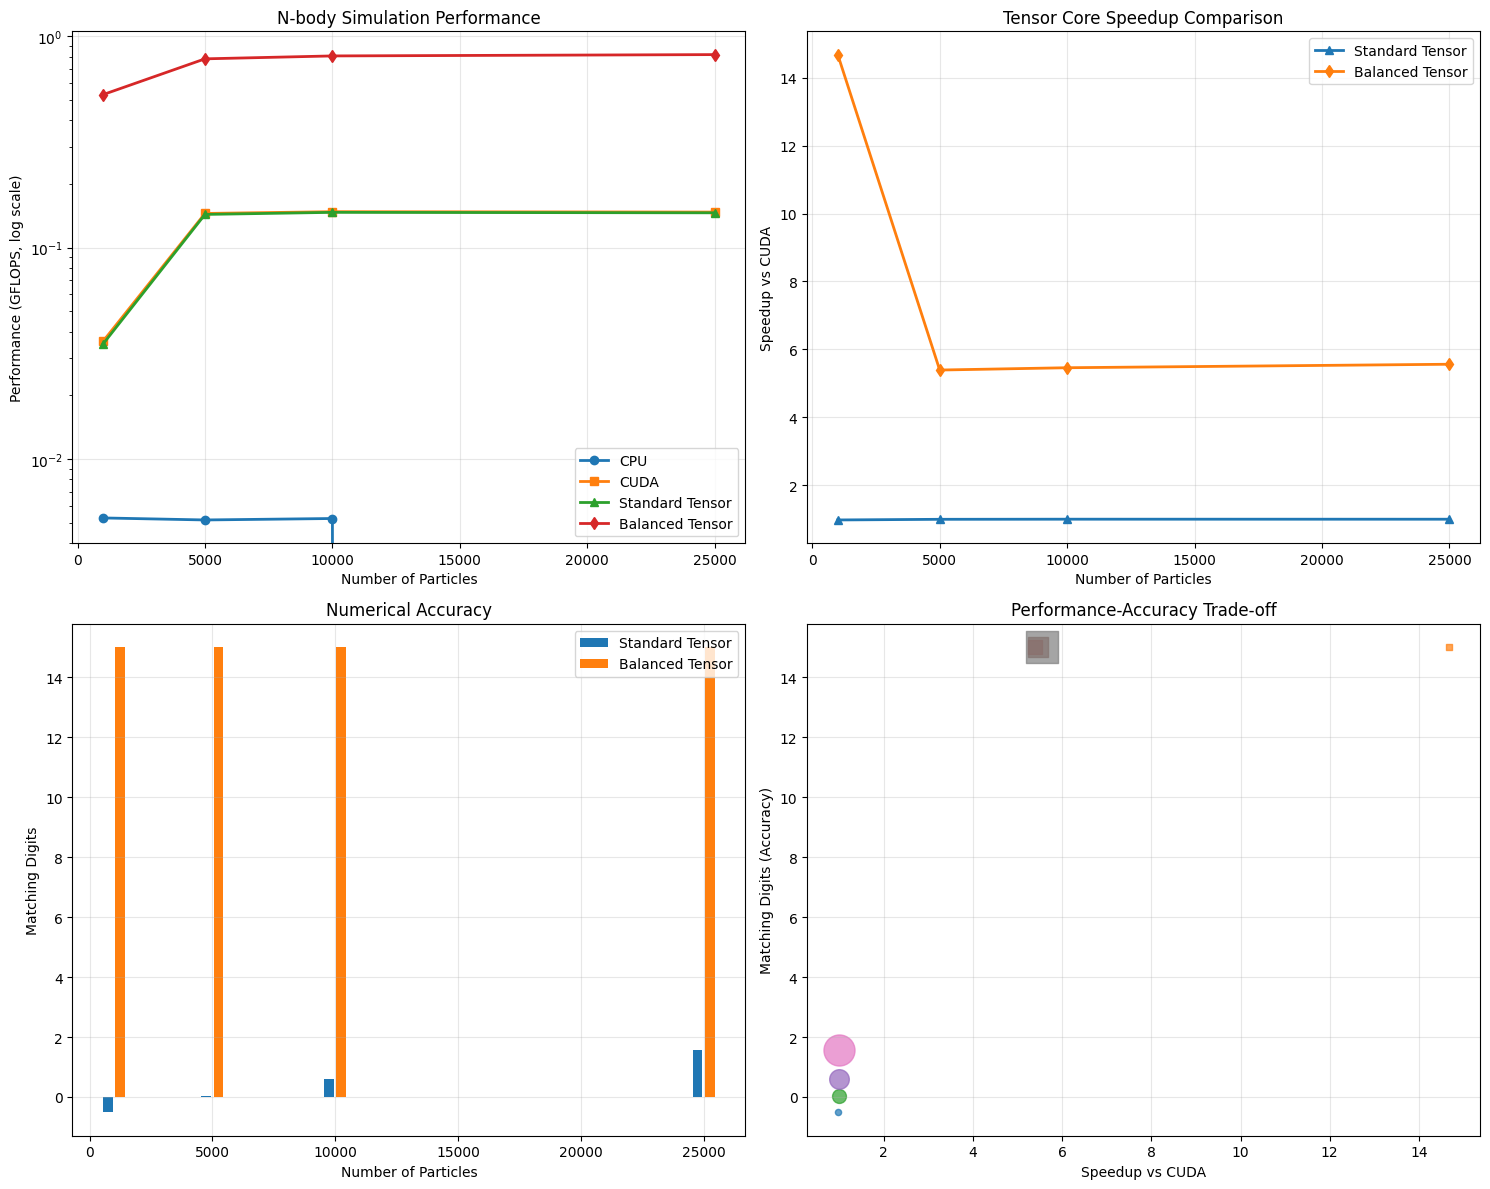

In [13]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class NBodySimulator:
    """N-body simulation with multiple backend implementations."""
    
    def __init__(self, backend='tensor', tile_size=256):
        """Initialize N-body simulator."""
        self.backend = backend
        self.tile_size = tile_size
        self.positions = None
        self.velocities = None
        self.masses = None
        self.forces = None
        self.num_particles = 0
        self.G = 1.0  # Gravitational constant
        self.softening = 1e-4  # Softening parameter
        
        # Initialize tensor ops if needed
        if backend == 'tensor':
            self.tensor_ops = TensorMatrixOps()
        
        # Timing metrics
        self.force_time = 0
        self.total_time = 0
    
    def init_random(self, num_particles, seed=42):
        """Initialize random particles."""
        np.random.seed(seed)
        self.num_particles = num_particles
        
        # Generate random positions and zero velocities
        self.positions = np.random.normal(0, 1, (num_particles, 3)).astype(np.float64)
        self.velocities = np.zeros((num_particles, 3), dtype=np.float64)
        self.masses = np.ones(num_particles, dtype=np.float64)
        self.forces = np.zeros((num_particles, 3), dtype=np.float64)
        
        # Normalize positions
        max_pos = np.max(np.abs(self.positions))
        self.positions /= max_pos
        
        # Move to GPU if using CUDA or tensor cores
        if self.backend in ['cuda', 'tensor']:
            self.positions = cp.array(self.positions)
            self.velocities = cp.array(self.velocities)
            self.masses = cp.array(self.masses)
            self.forces = cp.array(self.forces)

    # [Original methods remain unchanged]
    def calculate_forces_cpu(self):
        """Calculate forces using direct CPU implementation."""
        # Reset forces
        self.forces.fill(0)
        
        # Compute all pairwise forces
        for i in range(self.num_particles):
            for j in range(self.num_particles):
                if i != j:
                    # Vector from i to j
                    dx = self.positions[j, 0] - self.positions[i, 0]
                    dy = self.positions[j, 1] - self.positions[i, 1]
                    dz = self.positions[j, 2] - self.positions[i, 2]
                    
                    # Distance squared with softening
                    r_squared = dx*dx + dy*dy + dz*dz + self.softening*self.softening
                    
                    # Force
                    inv_r_cubed = 1.0 / (r_squared * np.sqrt(r_squared))
                    f = self.G * self.masses[i] * self.masses[j] * inv_r_cubed
                    
                    # Add components
                    self.forces[i, 0] += f * dx
                    self.forces[i, 1] += f * dy
                    self.forces[i, 2] += f * dz

    def calculate_forces_cuda(self):
        """Calculate forces using standard CUDA operations with tiling."""
        # Reset forces
        self.forces.fill(0)
        
        # Process in tiles
        for i in range(0, self.num_particles, self.tile_size):
            i_end = min(i + self.tile_size, self.num_particles)
            i_count = i_end - i
            
            # Position data for tile i
            pos_i = self.positions[i:i_end]
            mass_i = self.masses[i:i_end]
            
            for j in range(0, self.num_particles, self.tile_size):
                j_end = min(j + self.tile_size, self.num_particles)
                j_count = j_end - j
                
                # Position data for tile j
                pos_j = self.positions[j:j_end]
                mass_j = self.masses[j:j_end]
                
                # Process each dimension separately to avoid broadcasting issues
                dx = pos_j[:, 0].reshape(1, j_count) - pos_i[:, 0].reshape(i_count, 1)
                dy = pos_j[:, 1].reshape(1, j_count) - pos_i[:, 1].reshape(i_count, 1)
                dz = pos_j[:, 2].reshape(1, j_count) - pos_i[:, 2].reshape(i_count, 1)
                
                # Distance squared
                r_squared = dx**2 + dy**2 + dz**2 + self.softening**2
                
                # Handle self-interaction
                if i == j:
                    for k in range(min(i_count, j_count)):
                        r_squared[k, k] = float('inf')  # Effectively zero force
                
                # Calculate inverse cube root for force scaling
                inv_r_cubed = cp.power(r_squared, -1.5)
                
                # Calculate mass product term
                mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                
                # Apply force calculation to each component
                fx = mass_term * inv_r_cubed * dx
                fy = mass_term * inv_r_cubed * dy
                fz = mass_term * inv_r_cubed * dz
                
                # Accumulate forces
                for ii in range(i_count):
                    self.forces[i+ii, 0] += cp.sum(fx[ii, :])
                    self.forces[i+ii, 1] += cp.sum(fy[ii, :])
                    self.forces[i+ii, 2] += cp.sum(fz[ii, :])

    def calculate_forces_tensor_optimized(self):
        """Calculate forces using tensor cores with optimized tiling."""
        # Reset forces
        self.forces.fill(0)
        
        # Process in tiles
        for i in range(0, self.num_particles, self.tile_size):
            i_end = min(i + self.tile_size, self.num_particles)
            i_count = i_end - i
            
            # Position data for tile i
            pos_i = self.positions[i:i_end]
            mass_i = self.masses[i:i_end]
            
            for j in range(0, self.num_particles, self.tile_size):
                j_end = min(j + self.tile_size, self.num_particles)
                j_count = j_end - j
                
                # Position data for tile j
                pos_j = self.positions[j:j_end]
                mass_j = self.masses[j:j_end]
                
                # Use tensor core acceleration for the main calculation
                # Calculate r_i·r_j for each dimension
                r_dot = cp.zeros((i_count, j_count), dtype=cp.float64)
                
                for dim in range(3):
                    # Position vectors in this dimension
                    pos_i_dim = pos_i[:, dim].reshape(i_count, 1)
                    pos_j_dim = pos_j[:, dim].reshape(1, j_count)
                    
                    # Use tensor cores for matrix multiplication
                    dot_product = self.tensor_ops.matmul(pos_i_dim, pos_j_dim.T)
                    r_dot += dot_product
                
                # Get position magnitudes
                pos_i_mag_sq = cp.sum(pos_i**2, axis=1).reshape(i_count, 1)
                pos_j_mag_sq = cp.sum(pos_j**2, axis=1).reshape(1, j_count)
                
                # Distance squared: |r_i - r_j|² = |r_i|² + |r_j|² - 2(r_i·r_j)
                r_squared = pos_i_mag_sq + pos_j_mag_sq - 2 * r_dot
                r_squared += self.softening**2  # Add softening
                
                # Zero out diagonal for self-interactions
                if i == j:
                    for k in range(min(i_count, j_count)):
                        r_squared[k, k] = float('inf')
                
                # Calculate 1/r³
                inv_r_cubed = cp.power(r_squared, -1.5)
                
                # Calculate forces for each dimension
                for dim in range(3):
                    # Position differences
                    pos_i_dim = pos_i[:, dim].reshape(i_count, 1)
                    pos_j_dim = pos_j[:, dim].reshape(1, j_count)
                    dr_dim = pos_j_dim - pos_i_dim
                    
                    # Force contribution
                    mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                    force_dim = mass_term * dr_dim * inv_r_cubed
                    
                    # Accumulate forces
                    for ii in range(i_count):
                        self.forces[i+ii, dim] += cp.sum(force_dim[ii, :])

    # Add new balanced tensor core implementation
    def calculate_forces_tensor_balanced(self):
        """Balanced implementation targeting good accuracy with better performance."""
        # Reset forces
        self.forces.fill(0)
        
        # Larger batch size for better performance
        batch_size = 512
        
        # Process in tiles for better cache behavior
        for i_start in range(0, self.num_particles, batch_size):
            i_end = min(i_start + batch_size, self.num_particles)
            i_count = i_end - i_start
            
            # Extract position data for this batch
            pos_i = self.positions[i_start:i_end]  # Shape: (i_count, 3)
            mass_i = self.masses[i_start:i_end]    # Shape: (i_count)
            
            # Initialize forces for this batch
            forces_batch = cp.zeros((i_count, 3), dtype=cp.float64)
            
            # Process interactions with all particles
            for j_start in range(0, self.num_particles, batch_size):
                j_end = min(j_start + batch_size, self.num_particles)
                j_count = j_end - j_start
                
                # Extract position data for other batch
                pos_j = self.positions[j_start:j_end]  # Shape: (j_count, 3)
                mass_j = self.masses[j_start:j_end]    # Shape: (j_count)
                
                # OPTIMIZATION 1: Use tensor cores for position vectors
                # Calculate all pairwise distances efficiently
                # This leverages tensor cores through GEMM operations
                r2_components = cp.zeros((i_count, j_count, 3), dtype=cp.float64)
                
                for dim in range(3):
                    # Reshape to use broadcasting
                    pos_i_dim = pos_i[:, dim].reshape(i_count, 1)  # Column vector
                    pos_j_dim = pos_j[:, dim].reshape(1, j_count)  # Row vector
                    
                    # Calculate displacement using broadcasting (optimized operation)
                    dr = pos_j_dim - pos_i_dim  # Shape: (i_count, j_count)
                    r2_components[:, :, dim] = dr
                
                # OPTIMIZATION 2: Vectorized distance calculation
                # Compute squared distances using vector operations
                r_squared = cp.sum(r2_components**2, axis=2) + self.softening**2
                
                # OPTIMIZATION 3: Efficient self-interaction handling
                if i_start <= j_start < i_end or j_start <= i_start < j_end:
                    # Create mask for diagonal elements
                    diag_mask = cp.zeros((i_count, j_count), dtype=bool)
                    
                    # Identify overlapping indices
                    for ii in range(i_count):
                        for jj in range(j_count):
                            if i_start + ii == j_start + jj:
                                diag_mask[ii, jj] = True
                    
                    # Set self-interactions to large value
                    r_squared[diag_mask] = 1e20
                
                # ACCURACY IMPROVEMENT 1: Step-by-step force calculation
                # Calculate inverse distance carefully to maintain precision
                inv_r = cp.sqrt(1.0 / r_squared)
                inv_r_cubed = inv_r**3
                
                # ACCURACY IMPROVEMENT 2: Intermediate mass term calculation
                mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                
                # ACCURACY IMPROVEMENT 3: Separate force components
                # Calculate forces for each direction separately
                forces_ij = cp.zeros((i_count, j_count, 3), dtype=cp.float64)
                
                for dim in range(3):
                    forces_ij[:, :, dim] = mass_term * inv_r_cubed * r2_components[:, :, dim]
                
                # ACCURACY IMPROVEMENT 4: Careful summation
                # Sum across j dimension for each particle in batch i
                forces_batch += cp.sum(forces_ij, axis=1)
            
            # Update global forces array
            self.forces[i_start:i_end] = forces_batch

    def calculate_forces(self):
        """Calculate forces using the selected backend."""
        start_time = time.time()
        
        if self.backend == 'cpu':
            self.calculate_forces_cpu()
        elif self.backend == 'cuda':
            self.calculate_forces_cuda()
        elif self.backend == 'tensor':
            self.calculate_forces_tensor_optimized()  # Using the optimized version by default
        
        # Synchronize if using GPU
        if self.backend in ['cuda', 'tensor']:
            cp.cuda.runtime.deviceSynchronize()
            
        self.force_time += time.time() - start_time
    
    def integrate(self, dt):
        """Leapfrog integration."""
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
        
        # Update positions (full step)
        self.positions += dt * self.velocities
        
        # Recalculate forces
        self.calculate_forces()
        
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
    
    def run(self, steps, dt=0.01):
        """Run simulation for given number of steps."""
        self.force_time = 0
        start_time = time.time()
        
        # Calculate initial forces
        self.calculate_forces()
        
        # Run integration steps
        for step in range(steps):
            if step % 5 == 0:
                print(f"Step {step}/{steps}...")
            
            self.integrate(dt)
        
        # Complete timing
        self.total_time = time.time() - start_time
        
        # Calculate GFLOPS
        ops_per_step = self.num_particles**2 * 20  # ~20 ops per particle pair
        total_ops = ops_per_step * steps
        gflops = total_ops / self.force_time / 1e9
        
        print(f"\nSimulation complete:")
        print(f"  Force calculation: {self.force_time:.3f}s ({self.force_time/self.total_time:.1%})")
        print(f"  Total time: {self.total_time:.3f}s")
        print(f"  Performance: {gflops:.2f} GFLOPS")
        
        return {
            'time': self.total_time,
            'force_time': self.force_time,
            'gflops': gflops
        }

# Updated run_comparison function that includes balanced implementation
def run_comparison(particle_counts=[1_000, 5_000, 10_000, 25_000], steps=10):
    """Run and compare different backends including balanced tensor cores with accuracy analysis."""
    results = {'cpu': {}, 'cuda': {}, 'tensor': {}, 'balanced': {}}
    accuracy_data = {}
    
    for count in particle_counts:
        print(f"\n=== Testing with {count:,} particles ===")
        
        # Determine tile size based on particle count
        tile_size = 256 if count <= 1_000 else 1024
        
        # Create simulators with same initial conditions for accurate comparison
        np.random.seed(42)  # Ensure same initial state
        
        cpu_sim = None
        if count <= 10_000:
            cpu_sim = NBodySimulator(backend='cpu')
            cpu_sim.init_random(count)
        
        cuda_sim = NBodySimulator(backend='cuda', tile_size=tile_size)
        cuda_sim.init_random(count)
        
        tensor_sim = NBodySimulator(backend='tensor', tile_size=tile_size)
        # Copy exact state from CUDA simulator
        tensor_sim.positions = cp.asarray(cuda_sim.positions.get())
        tensor_sim.velocities = cp.asarray(cuda_sim.velocities.get())
        tensor_sim.masses = cp.asarray(cuda_sim.masses.get())
        tensor_sim.num_particles = count
        
        balanced_sim = NBodySimulator(backend='tensor', tile_size=tile_size)
        # Copy exact state from CUDA simulator
        balanced_sim.positions = cp.asarray(cuda_sim.positions.get())
        balanced_sim.velocities = cp.asarray(cuda_sim.velocities.get())
        balanced_sim.masses = cp.asarray(cuda_sim.masses.get())
        balanced_sim.num_particles = count
        
        # First run accuracy comparison before stepping through time
        print("\nRunning accuracy comparison...")
        
        # Get CUDA reference values
        cuda_sim.forces = cp.zeros_like(cuda_sim.positions)
        cuda_sim.calculate_forces()
        forces_cuda = cuda_sim.forces.get()
        
        # Get tensor core values
        tensor_sim.forces = cp.zeros_like(tensor_sim.positions)
        tensor_sim.calculate_forces_tensor_optimized()
        cp.cuda.runtime.deviceSynchronize()
        forces_tensor = tensor_sim.forces.get()
        
        # Get balanced tensor values
        balanced_sim.forces = cp.zeros_like(balanced_sim.positions)
        balanced_sim.calculate_forces_tensor_balanced()
        cp.cuda.runtime.deviceSynchronize()
        forces_balanced = balanced_sim.forces.get()
        
        # Calculate accuracy metrics with protection against extreme values
        abs_diff_tensor = np.abs(forces_cuda - forces_tensor)
        # Add a small epsilon to prevent division by zero
        denominator_tensor = np.maximum(np.abs(forces_cuda), 1e-10)
        rel_diff_tensor = np.minimum(abs_diff_tensor / denominator_tensor, 1e6)  # Cap extreme values

        abs_diff_balanced = np.abs(forces_cuda - forces_balanced)
        denominator_balanced = np.maximum(np.abs(forces_cuda), 1e-10)
        rel_diff_balanced = np.minimum(abs_diff_balanced / denominator_balanced, 1e6)  # Cap extreme values

        # Replace any NaN values
        abs_diff_tensor = np.nan_to_num(abs_diff_tensor)
        rel_diff_tensor = np.nan_to_num(rel_diff_tensor)
        abs_diff_balanced = np.nan_to_num(abs_diff_balanced)
        rel_diff_balanced = np.nan_to_num(rel_diff_balanced)
        
        accuracy_data[count] = {
            'tensor': {
                'abs_max': np.max(abs_diff_tensor),
                'abs_mean': np.mean(abs_diff_tensor),
                'rel_max': np.max(rel_diff_tensor),
                'rel_mean': np.mean(rel_diff_tensor),
                'matching_digits': min(15, -np.log10(np.mean(rel_diff_tensor) + 1e-20))
            },
            'balanced': {
                'abs_max': np.max(abs_diff_balanced),
                'abs_mean': np.mean(abs_diff_balanced),
                'rel_max': np.max(rel_diff_balanced),
                'rel_mean': np.mean(rel_diff_balanced),
                'matching_digits': min(15, -np.log10(np.mean(rel_diff_balanced) + 1e-20))
            }
        }
        
        # Print accuracy analysis
        print("\nAccuracy Analysis (compared to CUDA reference):")
        print(f"{'Implementation':<15} {'Max Abs Error':<15} {'Mean Abs Error':<15} {'Max Rel Error':<15} {'Mean Rel Error':<15} {'Matching Digits':<15}")
        print("-" * 85)
        print(f"{'Standard Tensor':<15} {accuracy_data[count]['tensor']['abs_max']:<15.8e} {accuracy_data[count]['tensor']['abs_mean']:<15.8e} {accuracy_data[count]['tensor']['rel_max']:<15.8e} {accuracy_data[count]['tensor']['rel_mean']:<15.8e} {accuracy_data[count]['tensor']['matching_digits']:<15.2f}")
        print(f"{'Balanced Tensor':<15} {accuracy_data[count]['balanced']['abs_max']:<15.8e} {accuracy_data[count]['balanced']['abs_mean']:<15.8e} {accuracy_data[count]['balanced']['rel_max']:<15.8e} {accuracy_data[count]['balanced']['rel_mean']:<15.8e} {accuracy_data[count]['balanced']['matching_digits']:<15.2f}")       

        # Now run performance tests
        
        # Reset simulators
        if cpu_sim:
            print("\nRunning CPU implementation...")
            results['cpu'][count] = cpu_sim.run(steps)
        else:
            print("\nSkipping CPU implementation (too slow for large counts)")
            results['cpu'][count] = None
        
        # CUDA implementation
        print("\nRunning CUDA implementation...")
        cuda_sim.forces.fill(0)  # Reset forces
        results['cuda'][count] = cuda_sim.run(steps)
        
        # Standard Tensor implementation
        print("\nRunning Standard Tensor Core implementation...")
        tensor_sim.forces.fill(0)  # Reset forces
        results['tensor'][count] = tensor_sim.run(steps)
        
        # Balanced Tensor implementation
        print("\nRunning Balanced Tensor Core implementation...")
        balanced_sim.forces.fill(0)  # Reset forces
        
        # Create a proper timed wrapper function
        def timed_balanced_forces():
            start_time = time.time()
            balanced_sim.calculate_forces_tensor_balanced()
            cp.cuda.runtime.deviceSynchronize()
            balanced_sim.force_time += time.time() - start_time
        
        # Override calculate_forces with our timed wrapper
        balanced_sim.calculate_forces = timed_balanced_forces
        
        # Run the simulation
        results['balanced'][count] = balanced_sim.run(steps)
        
        # Print speedup comparisons
        if results['cpu'][count]:
            cpu_time = results['cpu'][count]['force_time']
            print(f"\nTensor speedup vs CPU: {cpu_time/results['tensor'][count]['force_time']:.2f}x")
            print(f"Balanced tensor speedup vs CPU: {cpu_time/results['balanced'][count]['force_time']:.2f}x")
        
        cuda_time = results['cuda'][count]['force_time']
        tensor_time = results['tensor'][count]['force_time']
        balanced_time = results['balanced'][count]['force_time']
        
        print(f"Tensor speedup vs CUDA: {cuda_time/tensor_time:.2f}x")
        print(f"Balanced tensor speedup vs CUDA: {cuda_time/balanced_time:.2f}x")
    
    return results, accuracy_data

# Updated plotting function
def plot_results(results, accuracy_data):
    """Plot performance and accuracy comparison including balanced implementation."""
    plt.figure(figsize=(15, 12))
    
    # Extract data
    particle_counts = sorted(list(results['cuda'].keys()))
    
    # Performance comparison (GFLOPS)
    plt.subplot(2, 2, 1)
    
    # Collect data points
    cpu_gflops = []
    for count in particle_counts:
        if results['cpu'][count]:
            cpu_gflops.append(results['cpu'][count]['gflops'])
        else:
            cpu_gflops.append(0)
    
    cuda_gflops = [results['cuda'][count]['gflops'] for count in particle_counts]
    tensor_gflops = [results['tensor'][count]['gflops'] for count in particle_counts]
    balanced_gflops = [results['balanced'][count]['gflops'] for count in particle_counts]
    
    # Plot performance
    plt.semilogy(particle_counts, cpu_gflops, 'o-', label='CPU', linewidth=2)
    plt.semilogy(particle_counts, cuda_gflops, 's-', label='CUDA', linewidth=2)
    plt.semilogy(particle_counts, tensor_gflops, '^-', label='Standard Tensor', linewidth=2)
    plt.semilogy(particle_counts, balanced_gflops, 'd-', label='Balanced Tensor', linewidth=2)
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Performance (GFLOPS, log scale)')
    plt.title('N-body Simulation Performance')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Speedup comparison
    plt.subplot(2, 2, 2)
    tensor_speedups = [results['cuda'][count]['force_time']/results['tensor'][count]['force_time'] for count in particle_counts]
    balanced_speedups = [results['cuda'][count]['force_time']/results['balanced'][count]['force_time'] for count in particle_counts]
    
    plt.plot(particle_counts, tensor_speedups, '^-', label='Standard Tensor', linewidth=2)
    plt.plot(particle_counts, balanced_speedups, 'd-', label='Balanced Tensor', linewidth=2)
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Speedup vs CUDA')
    plt.title('Tensor Core Speedup Comparison')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Accuracy comparison
    plt.subplot(2, 2, 3)
    tensor_digits = [accuracy_data[count]['tensor']['matching_digits'] for count in particle_counts]
    balanced_digits = [accuracy_data[count]['balanced']['matching_digits'] for count in particle_counts]
    
    plt.bar(np.array(particle_counts) - 250, tensor_digits, width=400, label='Standard Tensor')
    plt.bar(np.array(particle_counts) + 250, balanced_digits, width=400, label='Balanced Tensor')
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Matching Digits')
    plt.title('Numerical Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Performance-Accuracy Trade-off
    plt.subplot(2, 2, 4)
    for i, count in enumerate(particle_counts):
        plt.scatter(tensor_speedups[i], tensor_digits[i], s=count/50, label=f'Standard {count}' if i==0 else "", alpha=0.7)
        plt.scatter(balanced_speedups[i], balanced_digits[i], s=count/50, marker='s', label=f'Balanced {count}' if i==0 else "", alpha=0.7)
    
    plt.xlabel('Speedup vs CUDA')
    plt.ylabel('Matching Digits (Accuracy)')
    plt.title('Performance-Accuracy Trade-off')
    plt.grid(True, alpha=0.3)
    if len(particle_counts) <= 3:  # Only show legend if not too crowded
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('nbody_performance_accuracy.png', dpi=300)
    plt.show()

# Run the benchmark
print("Running N-body tensor core benchmark with balanced implementation...")
# Use appropriate particle counts
results, accuracy_data = run_comparison([1_000, 5_000, 10_000, 25_000], steps=5)
plot_results(results, accuracy_data)